In [1]:
import warnings # To suppress warnings
warnings.filterwarnings("ignore")

# Importing Dependencies

import numpy as np
import pandas as pd
import sys
import os

from datetime import datetime #To get the different attributes from a date, like Day, Month, Year 

import matplotlib as mpl
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold,cross_val_score # All the necessary visualization libs
from sklearn.metrics import accuracy_score,r2_score,f1_score,log_loss,recall_score    # and evaluation metrics
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_error

import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance, plot_tree
from pai4sk import BoostingMachine

In [2]:
input_path = r"melbourne_temperature.csv"         # Path to the file contained in Drive
df = pd.read_table(input_path,sep = ',')                                      # Reading the dataframe from the csv file as a table

In [3]:
# Checking Basic information available from dataset

df.info()  # 2 columns are there === Date and Temperature
print("\n\n\n\n")
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3650 non-null   object 
 1   Temp    3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB







,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [4]:
# The column "Date" is of type string, we are converting it to the type "datetime" to process easily
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d',errors = 'coerce') 

# The column "Temp" is of type string, we are converting to type "float" 
df.Temp = df['Temp'].astype('float64')

         Date  Temp
0  1981-01-01  20.7
1  1981-01-02  17.9
2  1981-01-03  18.8
3  1981-01-04  14.6
4  1981-01-05  15.8


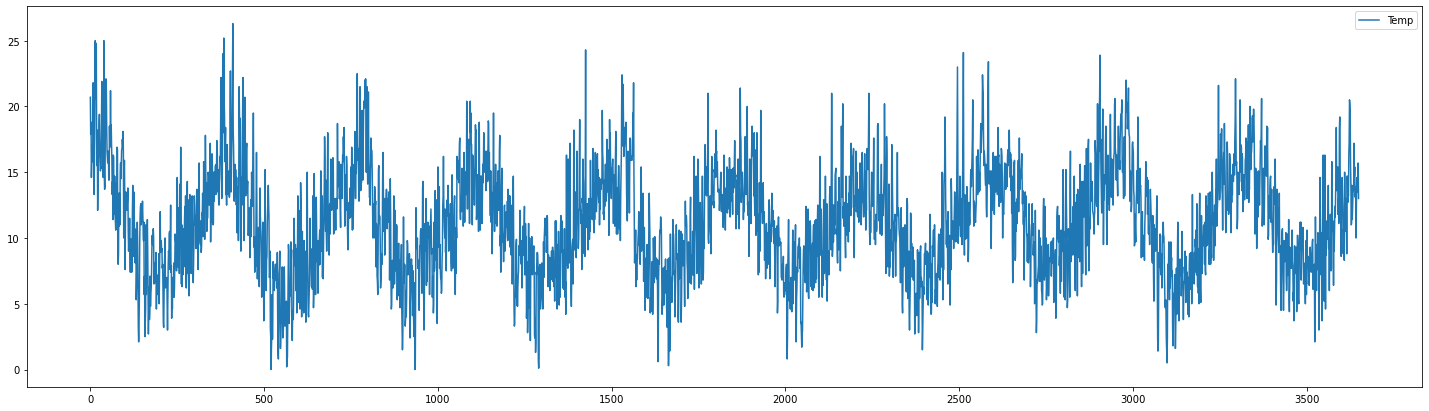

In [5]:
# Here I am Roughly plotting Entire data to know the Seasonality/Trend

series = pd.read_table("melbourne_temperature.csv",sep = ',')
print(series.head())
series.plot(figsize=(25,7))
plt.show()


## Data Shows a repeating pattern (or Seasonality) every 750 days (~ Approx 2 years once pattern repeats)

In [6]:
df['lag_1'] = df['Temp'].shift(1)
df = df[['Date', 'lag_1', 'Temp']]
df['lag_1'] = df.lag_1.fillna(20.7)
df.head()

,Date,lag_1,Temp
0,1981-01-01,20.7,20.7
1,1981-01-02,20.7,17.9
2,1981-01-03,17.9,18.8
3,1981-01-04,18.8,14.6
4,1981-01-05,14.6,15.8


In [7]:
split_date = round(df.Temp.count()*0.9)      # Total number of rows * 0.9 = 3650*0.9 
# print(split_date)                  
train = df.loc[:split_date].copy()    # Train set has 90% of the rows i.e 3286 days
test = df.loc[split_date:].copy()     # Validation set is 10% of the rows i.e. 365 days (1 year)

In [8]:
# The below function will generate features (feature engineering) using the "Date" column

def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.Date
    df['hour'] = df['date'].dt.hour  # Extracts the Hour from date if given
    df['dayofweek'] = df['date'].dt.dayofweek # Extracts day of the week 
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear # And so on....
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','lag_1']]
    if label:
        y = df[label]
        return X, y
    return X

In [9]:
train_x, train_y = create_features(train, label='Temp') ## Calling that function and assigning to the train and test sets ##
test_x, test_y = create_features(test, label='Temp')

In [10]:
train_x.info() # See the number of columns , now we have more X features, so we can improve accuracy
print("\n\n\n")
test_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   hour        3286 non-null   int64  
 1   dayofweek   3286 non-null   int64  
 2   quarter     3286 non-null   int64  
 3   month       3286 non-null   int64  
 4   year        3286 non-null   int64  
 5   dayofyear   3286 non-null   int64  
 6   dayofmonth  3286 non-null   int64  
 7   weekofyear  3286 non-null   int64  
 8   lag_1       3286 non-null   float64
dtypes: float64(1), int64(8)
memory usage: 231.2 KB




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 3285 to 3649
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   hour        365 non-null    int64  
 1   dayofweek   365 non-null    int64  
 2   quarter     365 non-null    int64  
 3   month       365 non-null    int64  
 4   year        365 non-null    

In [11]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from xgboost import XGBRegressor
xgb_hps = {  
            'learning_rate':     hp.loguniform('learning_rate', -5.0, -2.3),
            'max_depth':         hp.choice('max_depth',np.arange(5,30,1,dtype = int)),
            'lambda':            hp.quniform('lambda',2, 25, 1),
            'subsample':        hp.quniform('subsample',0.1,1.0,0.01),
            'colsample_bytree': hp.quniform('colsample_bytree',0.3, 0.8, 0.1),
            'min_split_loss' : hp.quniform('min_split_loss',0.1,5.5,0.1)
        }

depth_list = [i for i in range(5,16,1)]
accuracy_list_xgb = []
def HPO_xgb(xgb_hps):
    model = model = XGBRegressor(silent = True,n_estimators=1000,objective = "reg:squarederror",loss = "mse",**xgb_hps)
    model.fit(train_x,train_y)
    y_pred = model.predict(test_x)
    accuracy_xgb = r2_score(y_pred,test_y).mean()
    accuracy_list_xgb.append(accuracy_xgb)
    return {'loss': -accuracy_xgb, 'status': STATUS_OK }
trials = Trials()
best_xgb = fmin(fn= HPO_xgb,
            space= xgb_hps,
            algo= tpe.suggest,
            max_evals = 10,
            trials = trials
            )
max_acc_xgb = max(accuracy_list_xgb)
print("Best Hyperparameters for XGBoost are: \n")
best_xgb

100%|██████████| 10/10 [00:52<00:00,  5.27s/trial, best loss: -0.5480714227950984]
Best Hyperparameters for XGBoost are: 



{'colsample_bytree': 0.6000000000000001,
 'lambda': 10.0,
 'learning_rate': 0.006747262624423514,
 'max_depth': 4,
 'min_split_loss': 1.6,
 'subsample': 0.28}

Best max_depth   =   9
Best subsample   =   0.28
Best learning_rate   =   0.006747262624423514
Best min_split_loss   =   1.6
Best lambda   =   10.0
Best colsample_bytree   =   0.6000000000000001


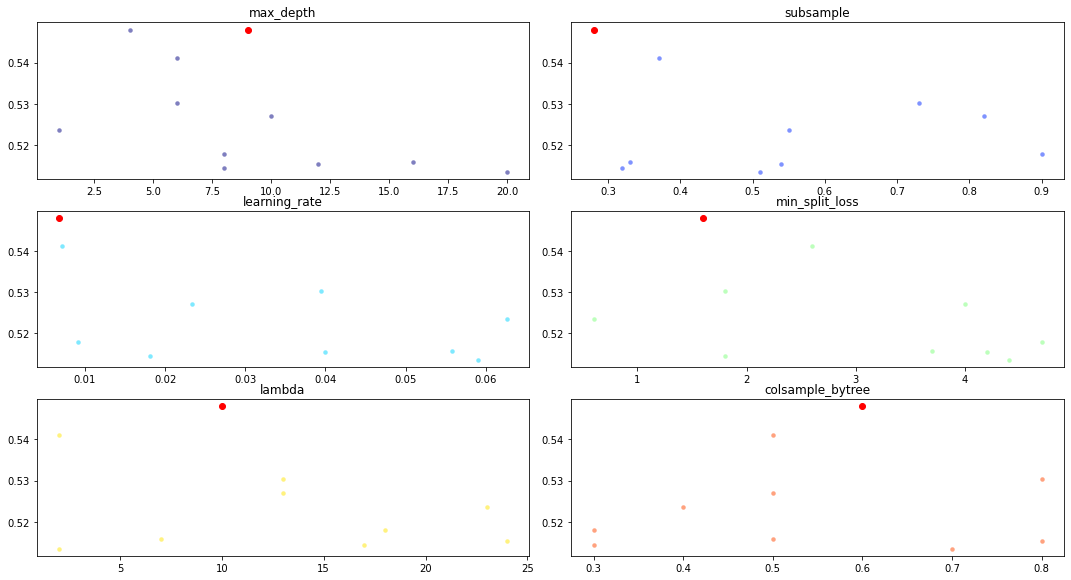

In [12]:
parameters = ['max_depth','subsample','learning_rate','min_split_loss','lambda','colsample_bytree']
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,8))
f.tight_layout()
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    if val == 'max_depth':
        best_xgb[val] = depth_list[best_xgb[val]]
    print("Best " + str(val) + "   =   " + str(best_xgb[val]))
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    c=np.array(cmap(float(i)/len(parameters)))
    axes[i//2,i%2].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=c.reshape(1,-1))
    axes[i//2,i%2].scatter(best_xgb[val],max_acc_xgb,color = "red")
    axes[i//2,i%2].set_title(val)

In [13]:
### XGBoost ####

reg = XGBRegressor(n_estimators=1000,objective = "reg:squarederror",loss = "mse",silent = True,**best_xgb)
t1=datetime.now()
reg.fit(train_x, train_y,
        eval_set=[(train_x, train_y), (test_x, test_y )],
        early_stopping_rounds=100,
       verbose=False)
t2=datetime.now()
execution_time_xgb = t2-t1
xgb_train_time = t2-t1
t3 = datetime.now()
y_pred = reg.predict(test_x)
t4 = datetime.now()
predictions = [round(value) for value in y_pred]
accuracy_xgb = round(r2_score(y_pred,test_y),2)
print("Accuracy score = ",accuracy_xgb*100,"%")
print("Execution time = ",execution_time_xgb)
print("Prediction time = ",t4-t3)

Accuracy score =  53.0 %
Execution time =  0:00:03.105164
Prediction time =  0:00:00.030201


In [14]:
print(max_acc_xgb)

0.5480714227950984


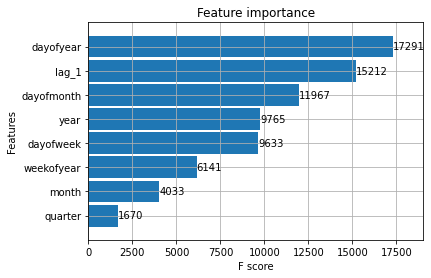

In [15]:
_ = plot_importance(reg, height=0.9) 

# This will show a graph of the F1 score,
# which shows how much importance is given to each feature

In [16]:
lgb_hps = { 'num_leaves': hp.choice('num_leaves',np.arange(100, 200, 10, dtype=int)),
            'max_depth': hp.choice('max_depth',np.arange(5, 16, 1, dtype=int)),
            #'n_estimators': hp.quniform('n_estimators', 10, 700, 1),
            'feature_fraction': hp.uniform('feature_fraction', 0.75, 1.0),
            'bagging_fraction': hp.uniform('bagging_fraction', 0.75, 1.0),
            'learning_rate': hp.loguniform('learning_rate', -5.0, -2.3),
            'lambda_l1': hp.uniform('lambda_l1', 0, 10),
            'lambda_l2': hp.uniform('lambda_l2', 0, 20)
          }

num_leaves_list = [i for i in range(100,200,10)]
## Manual Best till date Checkpoint ##
# params = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
# params['metric'] = ['auc', 'binary_logloss']
accuracy_list_lgbm = []
def HPO_lgbm(lgb_hps):
    num_round = 100
    train_data=lgb.Dataset(train_x,label=train_y)
    lgbm=lgb.LGBMRegressor(**lgb_hps)
    model = lgbm.fit(train_x,y=train_y)
    ypred2=model.predict(test_x)
    accuracy_lgbm = r2_score(test_y,ypred2).mean()
    accuracy_list_lgbm.append(accuracy_lgbm)
    return {'loss': -accuracy_lgbm, 'status': STATUS_OK }

In [17]:
trials = Trials()
best_lgbm = fmin(fn= HPO_lgbm,
            space= lgb_hps,
            algo= tpe.suggest,
            max_evals = 180,
            trials = trials
            )
max_acc_lgbm = max(accuracy_list_lgbm)
print("Best Hyperparameters for LGBM are: \n")
best_lgbm

100%|██████████| 180/180 [00:28<00:00,  6.29trial/s, best loss: -0.6742273646430051]
Best Hyperparameters for LGBM are: 



{'bagging_fraction': 0.9109298866694638,
 'feature_fraction': 0.9703439070235456,
 'lambda_l1': 8.015852368462305,
 'lambda_l2': 15.550120494242908,
 'learning_rate': 0.03368153803918311,
 'max_depth': 5,
 'num_leaves': 5}

Best num_leaves   =   5
Best max_depth   =   5
Best feature_fraction   =   0.9703439070235456
Best bagging_fraction   =   0.9109298866694638
Best learning_rate   =   0.03368153803918311
Best lambda_l1   =   8.015852368462305
Best lambda_l2   =   15.550120494242908


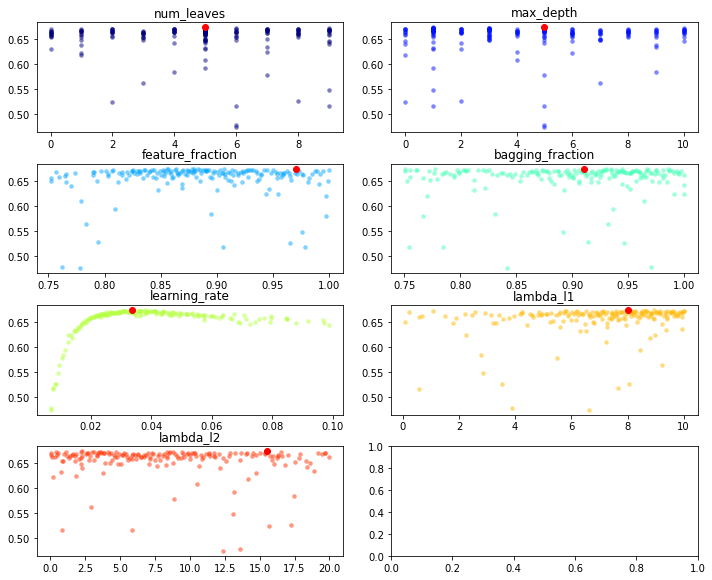

In [18]:
parameters = ['num_leaves','max_depth','feature_fraction','bagging_fraction','learning_rate','lambda_l1','lambda_l2']
f, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,8))
f.tight_layout()
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    print("Best " + str(val) + "   =   " + str(best_lgbm[val]))
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    c=np.array(cmap(float(i)/len(parameters)))
    axes[i//2,i%2].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=c.reshape(1,-1))
    axes[i//2,i%2].scatter(best_lgbm[val],max_acc_lgbm,color = "red")
    axes[i//2,i%2].set_title(val)

In [19]:
#### LightGBM #####

params = { 
            'num_leaves': num_leaves_list[best_lgbm['num_leaves']],
            'max_depth': best_lgbm['max_depth'],
            #'n_estimators': best_lgbm['n_estimators'],
            'feature_fraction':best_lgbm['feature_fraction'],
            'bagging_fraction':best_lgbm['bagging_fraction'],
            'learning_rate':best_lgbm['learning_rate'],
            'lambda_l1': best_lgbm['lambda_l1'],
            'lambda_l2':best_lgbm['lambda_l2']
          }
num_round=20
train_x_lgb= train_x
train_y_lgb = train_y
t1=datetime.now()
lgbr = lgb.LGBMRegressor(**params)
model = lgbr.fit(train_x_lgb,y=train_y_lgb)
t2=datetime.now()
execution_time_lgbm = t2-t1
t3=datetime.now()
y_pred = model.predict(test_x)
t4=datetime.now()
accuracy_lgbm = round(r2_score(test_y,y_pred),5)
print("Accuracy score = ",accuracy_lgbm*100,"%")
print("Execution time = ",execution_time_lgbm)
print("Prediction time = ",t4-t3)
lgbm_train_time = t2-t1

Accuracy score =  66.855 %
Execution time =  0:00:00.079798
Prediction time =  0:00:00.004275


In [20]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
num_threads = 25
sb_hps = {
            'objective': 'logloss',
#             'num_round': hp.uniform('num_round', 10, 700, 1),
            'min_max_depth':hp.choice('min_max_depth',np.arange(1,6,1,dtype = int)), 
            'max_max_depth':hp.choice('max_max_depth',np.arange(6,10,1,dtype = int)),
            'learning_rate':hp.loguniform('learning_rate', -5.0, -2.3), 
            'colsample_bytree': hp.quniform('colsample_bytree',0.3, 0.8, 0.1),
            'lambda_l2':hp.quniform('lambda_l2',2, 16, 1),
            'subsample':hp.quniform('subsample',0.3, 1.0, 0.1),
            'hist_nbins': 10,
            'random_state':42, 
            'n_threads':num_threads
}
depth_list_min = [i for i in range(1,6,1)]
depth_list_max = [i for i in range(6,10,1)]

In [21]:
accuracy_list_sb = []
def HPO_sb(sb_hps):
    model = model = BoostingMachine(**sb_hps)
    model.fit(train_x.to_numpy(),train_y.to_numpy())
    y_pred = model.predict(np.ascontiguousarray(test_x))
    accuracy_sb = r2_score(np.ascontiguousarray(test_y),y_pred).mean()
    accuracy_list_sb.append(accuracy_sb)
    return {'loss': -accuracy_sb, 'status': STATUS_OK }

In [22]:
trials = Trials()
best_sb = fmin(fn= HPO_sb,
            space= sb_hps,
            algo= tpe.suggest,
            max_evals = 180,
            trials = trials
            )
max_acc_sb = max(accuracy_list_sb)
print("Best Hyperparameters for SnapBoost are: \n")
best_sb

100%|██████████| 180/180 [00:16<00:00, 11.01trial/s, best loss: 6.930244328932357]
Best Hyperparameters for SnapBoost are: 



{'colsample_bytree': 0.5,
 'lambda_l2': 2.0,
 'learning_rate': 0.10023335665634811,
 'max_max_depth': 2,
 'min_max_depth': 2,
 'subsample': 0.9}

Best min_max_depth   =   3
Best max_max_depth   =   8
Best learning_rate   =   0.10023335665634811
Best colsample_bytree   =   0.5
Best lambda_l2   =   2.0
Best subsample   =   0.9


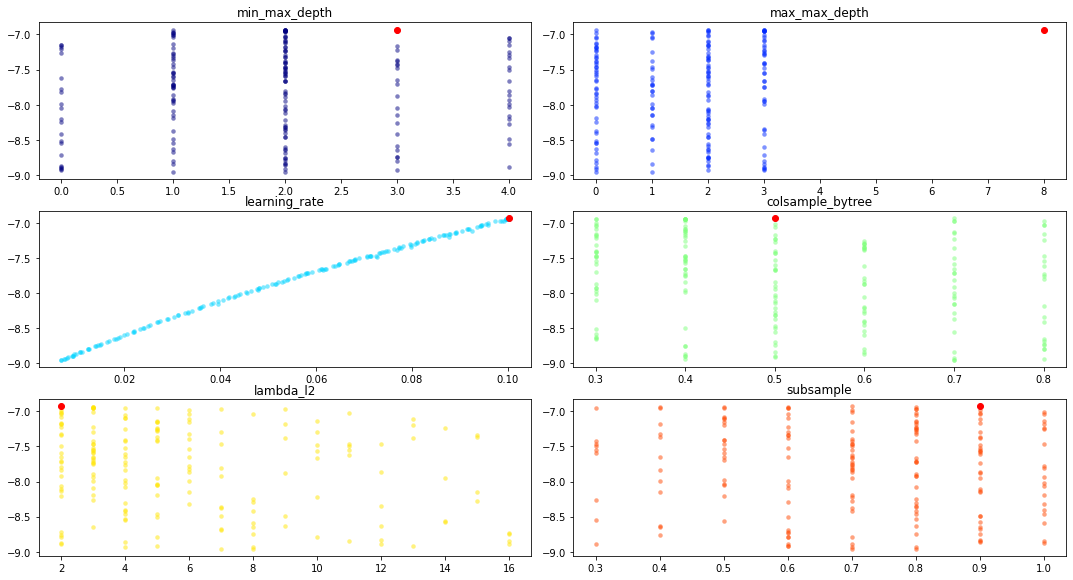

In [23]:
parameters = ['min_max_depth','max_max_depth','learning_rate','colsample_bytree','lambda_l2','subsample']
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,8))
f.tight_layout()
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    if val == 'min_max_depth' :
        best_sb[val] = depth_list_min[best_sb[val]]
    if val == 'max_max_depth':
        best_sb[val] = depth_list_max[best_sb[val]]
    print("Best " + str(val) + "   =   " + str(best_sb[val]))
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    c=np.array(cmap(float(i)/len(parameters)))
    axes[i//2,i%2].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=c.reshape(1,-1))
    axes[i//2,i%2].scatter(best_sb[val],max_acc_sb,color = "red")
    axes[i//2,i%2].set_title(val)

In [24]:
# max_max_depth = 6
# min_max_depth = 6
# num_round = 60
# learning_rate = 0.1
# num_threads = 25
booster = BoostingMachine()
t1=datetime.now()
booster.fit(train_x.to_numpy(), train_y.to_numpy())
t2=datetime.now()
execution_time_snap_boost = t2-t1
t3 = datetime.now()
ypred = booster.predict(np.ascontiguousarray(test_x))
t4 = datetime.now()
accuracy_snap_boost = round(100-mean_squared_error(test_y,ypred),2)/100
print("Accuracy score = ",accuracy_snap_boost*100,"%")
print("Execution time = ",execution_time_snap_boost)
print("Prediction time = ",t4-t3)
snap_boost_train_time = t2-t1

Accuracy score =  75.64 %
Execution time =  0:00:00.020900
Prediction time =  0:00:00.000631


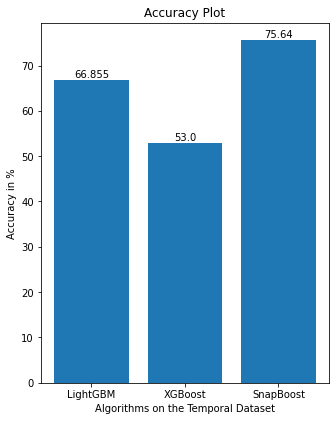

In [25]:
##### Accuracy Plot #####

import matplotlib.pyplot as plt
fig = plt.figure(figsize = (4,5))
ax = fig.add_axes([0,0,1,1])
algorithms = ['LightGBM','XGBoost','SnapBoost']
accuracy = [accuracy_lgbm*100, accuracy_xgb*100,accuracy_snap_boost*100]
g = ax.bar(algorithms,accuracy)
plt.title("Accuracy Plot")
plt.xlabel("Algorithms on the Temporal Dataset")
plt.ylabel("Accuracy in %")
bar_label = [accuracy_lgbm*100, accuracy_xgb*100,accuracy_snap_boost*100]
def autolabel(rects):
    for idx,rect in enumerate(g):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel(g)
plt.show()

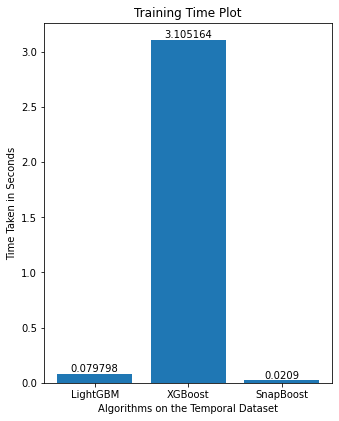

In [26]:
##### Training Time Plot ####

lg = float(str(lgbm_train_time)[5:])
cb = float(str(snap_boost_train_time)[5:])
xgb = float(str(xgb_train_time)[5:])
fig1 = plt.figure(figsize = (4,5))
ay = fig1.add_axes([0,0,1,1])
algorithms = ['LightGBM','XGBoost','SnapBoost']
training_time = [lg,xgb,cb]
g1 = ay.bar(algorithms,training_time)
plt.title("Training Time Plot")
plt.xlabel("Algorithms on the Temporal Dataset")
plt.ylabel("Time Taken in Seconds")
bar_label = training_time
def autolabel1(rects):
    for idx,rect in enumerate(g1):
        height = rect.get_height()
        ay.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel1(g1)
plt.show()